In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
data_train = pd.read_csv('/content/BBCA.csv')
data_train.head()

,date,previous,open_price,first_trade,high,low,close,change,volume,value,...,bid_volume,listed_shares,tradeble_shares,weight_for_index,foreign_sell,foreign_buy,delisting_date,non_regular_volume,non_regular_value,non_regular_frequency
0,2019-07-29T00:00:00,30975.0,31100.0,31100.0,31150.0,30800.0,30950.0,-25.0,13701900.0,4.246726e+11,...,1250400.0,2.440846e+10,2.440846e+10,2.440846e+10,4199100.0,3782800.0,NaN,6607083.0,2.056272e+11,39.0
1,2019-07-30T00:00:00,30950.0,31025.0,31025.0,31250.0,30950.0,31100.0,150.0,7645100.0,2.375243e+11,...,1900.0,2.440846e+10,2.440846e+10,2.440846e+10,3859500.0,4278300.0,NaN,8274494.0,2.570538e+11,44.0
2,2019-07-31T00:00:00,31100.0,30950.0,31100.0,31200.0,30900.0,30950.0,-150.0,12825800.0,3.977603e+11,...,1223000.0,2.440846e+10,2.440846e+10,2.440846e+10,7957300.0,8680200.0,NaN,10022093.0,3.113416e+11,57.0
3,2019-08-01T00:00:00,30950.0,30950.0,30950.0,31350.0,30925.0,31050.0,100.0,15645600.0,4.865419e+11,...,19500.0,2.440846e+10,2.440846e+10,2.440846e+10,6683700.0,13290800.0,NaN,7091288.0,2.210745e+11,35.0
4,2019-08-02T00:00:00,31050.0,30800.0,30825.0,31025.0,30800.0,30825.0,-225.0,12597900.0,3.892295e+11,...,1027000.0,2.440846e+10,2.440846e+10,2.440846e+10,9195000.0,2639100.0,NaN,2103060.0,6.523255e+10,32.0


In [3]:
data_train.isnull().sum()
data_train = data_train[['date', 'volume']]

In [4]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()

In [5]:
dates = data_train['date'].values
# print(data_train['volume'])

# Extract 'volume' column
volume = data_train['volume'].values.reshape(-1, 1)

# Fit and transform the data
normalized_volume = min_max_scaler.fit_transform(volume)

# Add normalized values back to the DataFrame
normalized_volume = normalized_volume.flatten()
print(data_train)

print(f"Total row data: {data_train['volume'].count()}")

                     date      volume
0     2019-07-29T00:00:00  13701900.0
1     2019-07-30T00:00:00   7645100.0
2     2019-07-31T00:00:00  12825800.0
3     2019-08-01T00:00:00  15645600.0
4     2019-08-02T00:00:00  12597900.0
...                   ...         ...
1065  2023-12-01T00:00:00  80566400.0
1066  2023-12-04T00:00:00  54750100.0
1067  2023-12-05T00:00:00  94363900.0
1068  2023-12-06T00:00:00  81852800.0
1069  2023-12-07T00:00:00  91322500.0

[1070 rows x 2 columns]
Total row data: 1070


Text(0.5, 1.0, 'Temperature Average')

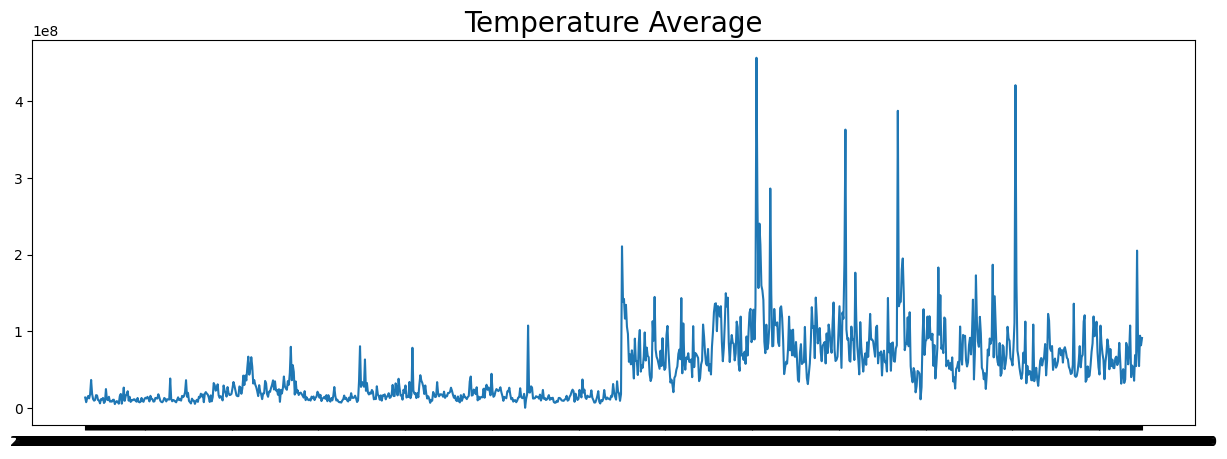

In [6]:
plt.figure(figsize=(15, 5))
plt.plot(dates, volume)
plt.title('Temperature Average',
            fontsize=20)

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
print(f"total dataset: {len(normalized_volume)}")
train_size = int(len(normalized_volume) * 0.8)
print(f"total train 80%: {train_size}")

train_volume, val_volume = normalized_volume[:train_size], normalized_volume[train_size:]
print(f"total val 20%: {len(val_volume)}")

total dataset: 1070
total train 80%: 856
total val 20%: 214


In [9]:
train_set = windowed_dataset(train_volume, 60, 100, 1000)
val_set = windowed_dataset(val_volume, 60, 100, 1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [10]:
import datetime
import os
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping

num_epochs = 100

experiment_name = f"initial_state_forecast_BBCA-volume_{num_epochs}-epoch"
date_now = datetime.datetime.now().strftime("_%d-%m-%Y_%H-%M-%S")

lokasiModel = os.path.join(f"train//{experiment_name + date_now}", experiment_name + '.h5')
lokasiCSV = os.path.join(f"train//{experiment_name + date_now}", experiment_name + '.csv')

callbacks = [
    ModelCheckpoint(lokasiModel, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_mae", factor=0.1, patience=3, min_lr=1e-6, verbose=1),
    CSVLogger(lokasiCSV),
    EarlyStopping(monitor="val_mae", patience=2, restore_best_weights=False)
]

In [12]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, validation_data=val_set, callbacks=callbacks)

Epoch 1/100
      5/Unknown - 6s 15ms/step - loss: 0.0046 - mae: 0.0625
Epoch 1: val_loss improved from inf to 0.00475, saving model to train//initial_state_forecast_BBCA-volume_100-epoch_19-12-2023_09-46-44/initial_state_forecast_BBCA-volume_100-epoch.h5
8/8 [==============================] - 8s 195ms/step - loss: 0.0041 - mae: 0.0623 - val_loss: 0.0047 - val_mae: 0.0543 - lr: 0.0100
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/8 [=========================>....] - ETA: 0s - loss: 0.0035 - mae: 0.0597
Epoch 2: val_loss did not improve from 0.00475
8/8 [==============================] - 1s 45ms/step - loss: 0.0041 - mae: 0.0614 - val_loss: 0.0049 - val_mae: 0.0556 - lr: 0.0100
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.0041 - mae: 0.0621
Epoch 3: val_loss improved from 0.00475 to 0.00459, saving model to train//initial_state_forecast_BBCA-volume_100-epoch_19-12-2023_09-46-44/initial_state_forecast_BBCA-volume_100-epoch.h5
8/8 [==============================] - 0s 50ms/step - loss: 0.0041 - mae: 0.0621 - val_loss: 0.0046 - val_mae: 0.0526 - lr: 0.0100
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.0040 - mae: 0.0617
Epoch 4: val_loss did not improve from 0.00459
8/8 [==============================] - 1s 59ms/step - loss: 0.0040 - mae: 0.0617 - val_loss: 0.0048 - val_mae: 0.0547 - lr: 0.0100
Epoch 5/100
8/8 [==============================] - ETA: 0s - loss: 0.0040

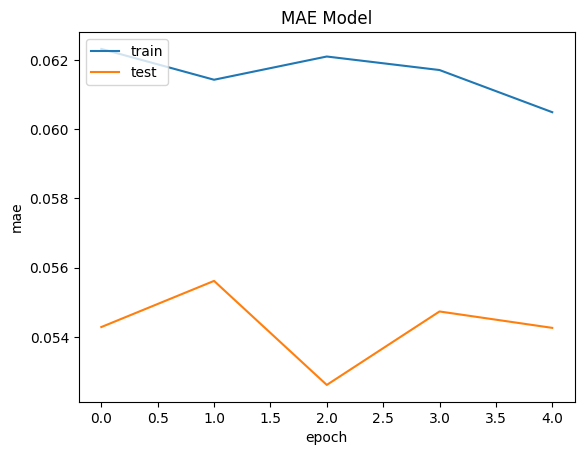

In [13]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE Model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

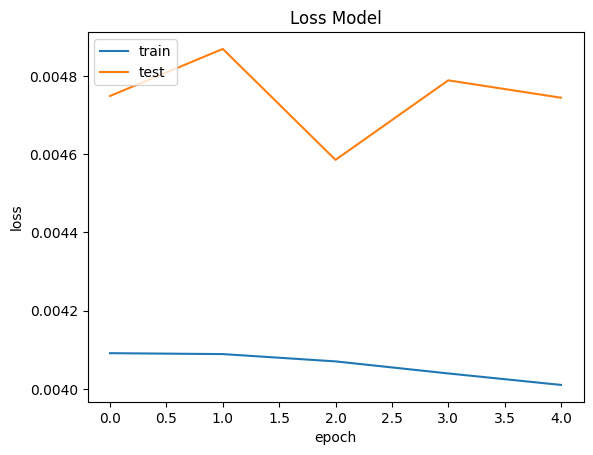

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()